In [17]:
import numpy as np
from matplotlib import pyplot as plt


# Get names of columns
data=np.genfromtxt('galaxyquasar.csv', delimiter=',', names=True, usecols=(0,1,2,3,4,6))
names = data.dtype.names
print(names)

#Get data without last column (z-error)
data=np.genfromtxt('galaxyquasar.csv', delimiter=',',skip_header=1,usecols=(0,1,2,3,4,6),dtype=float)
print(data.shape)
print(data[0])

#Get true labels
labels = np.genfromtxt('galaxyquasar.csv', delimiter=',', skip_header=1, usecols=(5), dtype=str)
print(labels.shape)
print(labels[0:10])

('u', 'g', 'r', 'i', 'z', 'z1')
(50000, 6)
[18.97213   18.53676   18.5828    18.34936   18.29215    0.5228189]
(50000,)
['QSO' 'GALAXY' 'GALAXY' 'GALAXY' 'QSO' 'GALAXY' 'GALAXY' 'QSO' 'GALAXY'
 'GALAXY']


In [18]:
ug_set = data[:,0] - data[:, 1]
gr_set = data[:, 1] - data[:, 2]
ri_set = data[:, 2] - data[:, 3]
iz_set = data[:, 3] - data[:, 4]
labels = np.array([1 if label == 'QSO' else 0 for label in labels])
names = ["ug_set", "gr_set", "ri_set", "iz_set"]

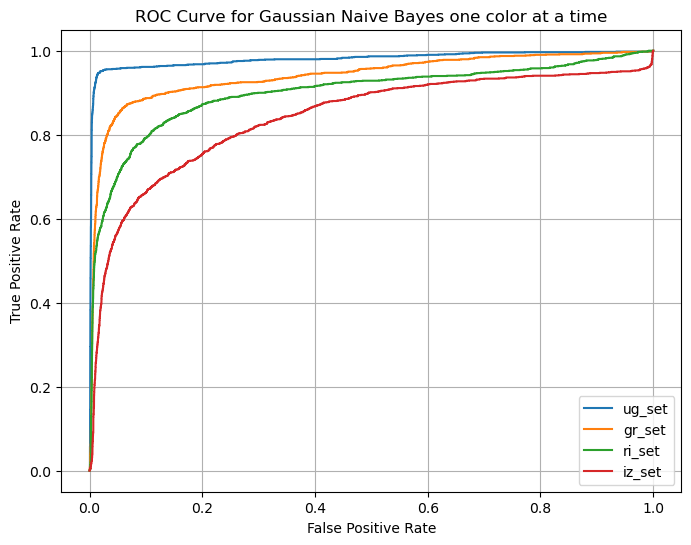

In [19]:
#CLASSIFICATION BY GAUSSIAN NAIVE BAYES

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from astroML.utils import completeness_contamination
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

X_tot = np.column_stack((ug_set,gr_set,ri_set,iz_set))
X = X_tot
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

fig1, ax1 = plt.subplots(figsize=(8, 6))

for j in range(4):
    # Select one color at a time
    clf = GaussianNB()
    clf.fit(X_train[:, j:j+1], y_train)
    y_prob = clf.predict_proba(X_test[:,j:j+1])[:, 1]
    fpr_gnb, tpr_gnb, thresh_gnb = roc_curve(y_test, y_prob)
    ax1.plot(fpr_gnb, tpr_gnb, label=f'{names[j]}')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve for Gaussian Naive Bayes one color at a time')
ax1.legend()
ax1.grid()

Confusion Matrix for threshold = 0.5 for 1 colors:
 [[8480   92]
 [ 106 1322]]
At threshold = 0.5 with 1 components
Completeness: 0.926   Precision: 0.935

Confusion Matrix for threshold = 0.5 for 2 colors:
 [[8422  150]
 [ 107 1321]]
At threshold = 0.5 with 2 components
Completeness: 0.925   Precision: 0.898

Confusion Matrix for threshold = 0.5 for 3 colors:
 [[8433  139]
 [ 107 1321]]
At threshold = 0.5 with 3 components
Completeness: 0.925   Precision: 0.905

Confusion Matrix for threshold = 0.5 for 4 colors:
 [[8419  153]
 [ 108 1320]]
At threshold = 0.5 with 4 components
Completeness: 0.924   Precision: 0.896



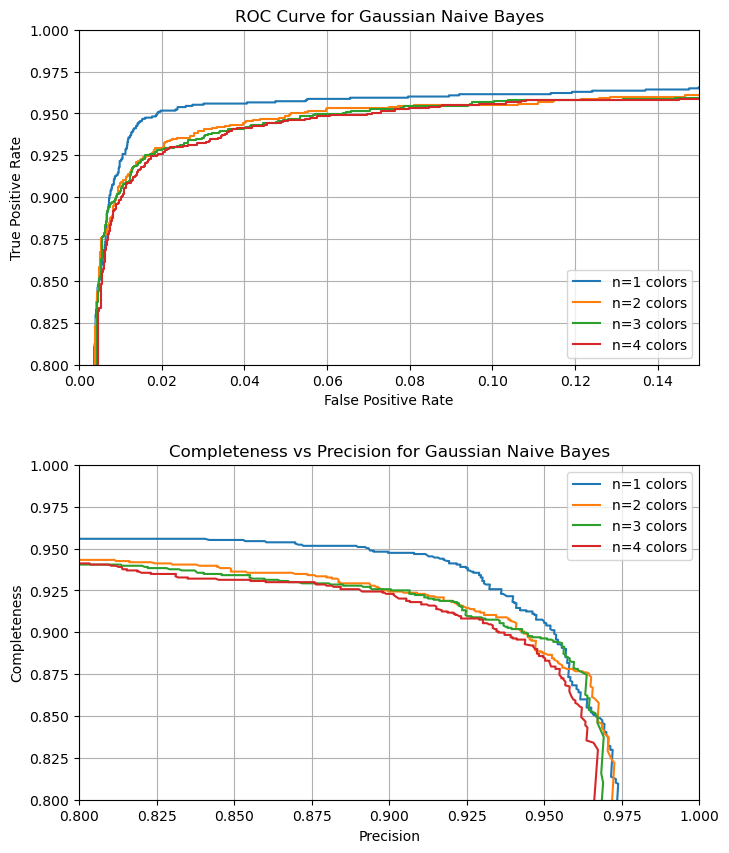

In [24]:

#Starting classification with U-G and G-R colors


fig2,ax2 = plt.subplots(2,1, figsize=(8, 10))

clf_gnb=[]
thresholds = np.linspace(0, 1, 1000)
for nc in range(1,5):
    clf = GaussianNB()
    clf.fit(X_train[:,:nc], y_train)
    clf_gnb.append(clf)

    # Predicting the labels for the test set with default threshold:0.5
    y_pred = clf.predict(X_test[:,:nc])
    conf_mat = confusion_matrix(y_test, y_pred)
    comp, cont = completeness_contamination(y_pred, y_test)
    print(f"Confusion Matrix for threshold = 0.5 for {nc} colors:\n", conf_mat)
    print(f"At threshold = 0.5 with {nc} components\nCompleteness: {comp:.3f}   Precision: {1-cont:.3f}\n")

    #Computing ROC curve varying the threshold to choose the best one
    y_prob = clf.predict_proba(X_test[:,:nc])[:, 1]
    fpr_gnb, tpr_gnb, thresh_gnb = roc_curve(y_test, y_prob)

    ax2[0].plot(fpr_gnb, tpr_gnb, label=f'n={nc} colors')
    
    comp_gnb, cont_gnb = np.zeros(len(thresholds)), np.zeros(len(thresholds))
    for n,t in zip(np.arange(len(thresholds)), thresholds):
        y_pred = np.zeros(len(y_test))
        y_pred[clf.predict_proba(X_test[:,:nc])[:, 1] > t] = 1
        comp_gnb[n], cont_gnb[n] = completeness_contamination(y_pred, y_test)

    ax2[1].plot(1-cont_gnb, comp_gnb, label=f'n={nc} colors')

ax2[0].set_xlabel('False Positive Rate')
ax2[0].set_ylabel('True Positive Rate')
ax2[0].set_title('ROC Curve for Gaussian Naive Bayes')
ax2[0].set_xlim([0, 0.15])
ax2[0].set_ylim([0.8, 1.0])
ax2[0].grid()
ax2[0].legend()

ax2[1].set_xlabel('Precision')
ax2[1].set_ylabel('Completeness')
ax2[1].set_title('Completeness vs Precision for Gaussian Naive Bayes')
ax2[1].set_xlim([0.8, 1])
ax2[1].set_ylim([0.8, 1.0])
ax2[1].grid()
ax2[1].legend()
fig2.subplots_adjust(hspace=0.3)


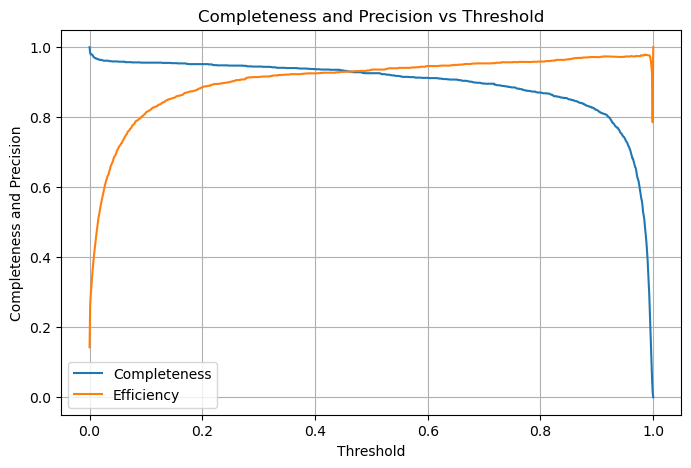

In [25]:
comp_gnb, cont_gnb = np.zeros(len(thresholds)), np.zeros(len(thresholds))
for n,t in zip(np.arange(len(thresholds)), thresholds):
    y_pred = np.zeros(len(y_test))
    y_pred[clf_gnb[0].predict_proba(X_test[:,[0]])[:, 1] > t] = 1
    comp_gnb[n], cont_gnb[n] = completeness_contamination(y_pred, y_test)

fig3,ax3 = plt.subplots(figsize=(8, 5))
ax3.plot(thresholds, comp_gnb, label='Completeness')
ax3.plot(thresholds, 1-cont_gnb, label='Efficiency')
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Completeness and Precision')

ax3.set_title('Completeness and Precision vs Threshold')
ax3.legend()
ax3.grid()


At threshold = 0.5 with 1 colors
Completeness: 0.924   Precision: 0.934

At threshold = 0.5 with 2 colors
Completeness: 0.931   Precision: 0.944

At threshold = 0.5 with 3 colors
Completeness: 0.932   Precision: 0.947

At threshold = 0.5 with 4 colors
Completeness: 0.925   Precision: 0.952



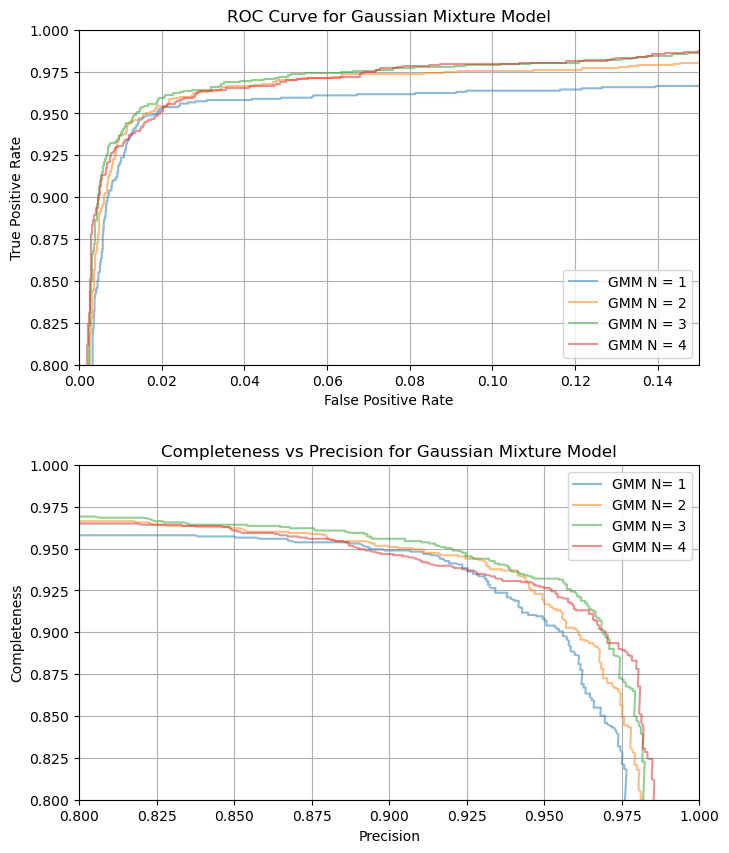

In [27]:
#REPEATING CLASSIFICATION WITH GMM BAYESIAN CLASSIFIER

from astroML.classification import GMMBayes

fig5, ax5 = plt.subplots(2, 1, figsize=(8, 10))

clf_gmm = []

for nc in range(1,5):
    
    clf = GMMBayes(8,covariance_type='full', tol=1e-4, random_state=42)
    clf.fit(X_train[:,:nc], y_train)
    clf_gmm.append(clf)
    y_prob = clf.predict_proba(X_test[:,:nc])[:, 1]
    fpr_gmm, tpr_gmm, thresh_gmm = roc_curve(y_test, y_prob)

   
# Plotting ROC curve
    ax5[0].plot(fpr_gmm, tpr_gmm, label=f'GMM N = {nc}', alpha=0.5)


#Plotting completeness vs precision
    comp_gmm, cont_gmm = np.zeros(len(thresholds)), np.zeros(len(thresholds))
    for n,t in zip(np.arange(len(thresholds)), thresholds):
        y_pred = np.zeros(len(y_test))
        y_pred[clf.predict_proba(X_test[:,:nc])[:, 1] > t] = 1
        comp_gmm[n], cont_gmm[n] = completeness_contamination(y_pred, y_test)
    ax5[1].plot(1-cont_gmm, comp_gmm, label=f'GMM N= {nc}', alpha=0.5)
    idx_05 = np.argmin(np.abs(thresholds - 0.5))
    print(f"At threshold = 0.5 with {nc} colors\nCompleteness: {comp_gmm[idx_05]:.3f}   Precision: {1-cont_gmm[idx_05]:.3f}\n")



ax5[0].set_xlabel('False Positive Rate')
ax5[0].set_ylabel('True Positive Rate')
ax5[0].set_xlim([0, 0.15])
ax5[0].set_ylim([0.8, 1.0])
ax5[0].set_title('ROC Curve for Gaussian Mixture Model')
ax5[0].legend()
ax5[0].grid()

ax5[1].set_xlabel('Precision')
ax5[1].set_ylabel('Completeness')
ax5[1].set_xlim([0.8, 1])
ax5[1].set_ylim([0.8, 1.0])
ax5[1].set_title('Completeness vs Precision for Gaussian Mixture Model')
ax5[1].legend()
ax5[1].grid()
fig5.subplots_adjust(hspace=0.3)


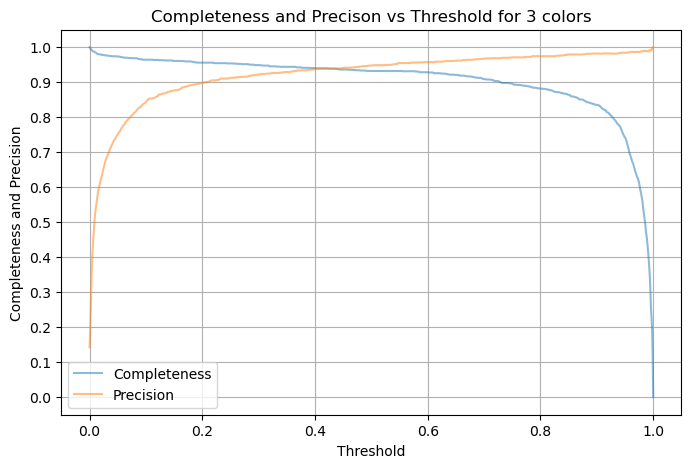

In [ ]:
fig6,ax6 = plt.subplots(figsize=(8, 5))
comp_gmm, cont_gmm = np.zeros(len(thresholds)), np.zeros(len(thresholds))
for n,t in zip(np.arange(len(thresholds)), thresholds):
    y_pred = np.zeros(len(y_test))
    y_pred[clf_gmm[2].predict_proba(X_test[:,:3])[:, 1] > t] = 1
    comp_gmm[n], cont_gmm[n] = completeness_contamination(y_pred, y_test)
ax6.plot(thresholds, comp_gmm, alpha = 0.5, label ='Completeness')
ax6.plot(thresholds, 1-cont_gmm, alpha = 0.5, label ='Precision')
ax6.set_xlabel('Threshold')
ax6.set_ylabel('Completeness and Precision')
ax6.legend()
ax6.set_title('Completeness and Precison vs Threshold for 3 colors')
ax6.set_yticks(np.arange(0, 1.1, 0.1))
ax6.grid()


At threshold = 0.5 with 1 colors
Completeness: 0.926   Precision: 0.931

At threshold = 0.5 with 2 colors
Completeness: 0.933   Precision: 0.928

At threshold = 0.5 with 3 colors
Completeness: 0.939   Precision: 0.949

At threshold = 0.5 with 4 colors
Completeness: 0.944   Precision: 0.949



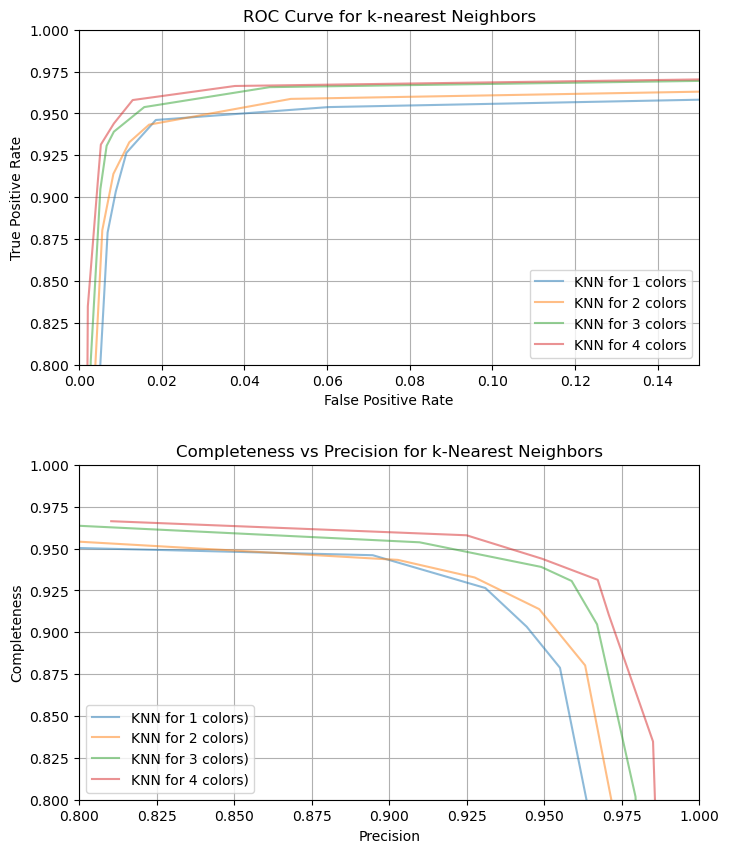

In [29]:
#LASTLY, CLASSIFICATION BY K-NEAREST NEIGHBOURS
from sklearn.neighbors import KNeighborsClassifier

fig8, ax8 = plt.subplots(2, 1, figsize=(8, 10))

clf_knn = []

for nc in range(1,5):
    clf = KNeighborsClassifier(n_neighbors=6)
    clf.fit(X_train[:,:nc], y_train)
    clf_knn.append(clf)
    y_prob = clf.predict_proba(X_test[:,:nc])[:, 1]
    fpr_knn, tpr_knn, thresh_knn = roc_curve(y_test, y_prob)
    ax8[0].plot(fpr_knn, tpr_knn, label=f'KNN for {nc} colors', alpha=0.5)

    comp_knn, cont_knn = np.zeros(len(thresholds)), np.zeros(len(thresholds))
    for n,t in zip(np.arange(len(thresholds)), thresholds):
        y_pred = np.zeros(len(y_test))
        y_pred[clf.predict_proba(X_test[:,:nc])[:, 1] > t] = 1
        comp_knn[n], cont_knn[n] = completeness_contamination(y_pred, y_test)
    ax8[1].plot(1-cont_knn, comp_knn, label=f'KNN for {nc} colors)', alpha=0.5)
    print(f"At threshold = 0.5 with {nc} colors\nCompleteness: {comp_knn[idx_05]:.3f}   Precision: {1-cont_knn[idx_05]:.3f}\n")

ax8[0].set_xlabel('False Positive Rate')
ax8[0].set_ylabel('True Positive Rate')
ax8[0].set_xlim([0, 0.15])
ax8[0].set_ylim([0.8, 1.0])
ax8[0].set_title('ROC Curve for k-nearest Neighbors')
ax8[0].legend()
ax8[0].grid()

ax8[1].set_xlabel('Precision')
ax8[1].set_ylabel('Completeness')
ax8[1].set_xlim([0.8, 1])
ax8[1].set_ylim([0.8, 1.0])
ax8[1].set_title('Completeness vs Precision for k-Nearest Neighbors')
ax8[1].legend()
ax8[1].grid()
fig8.subplots_adjust(hspace=0.3)

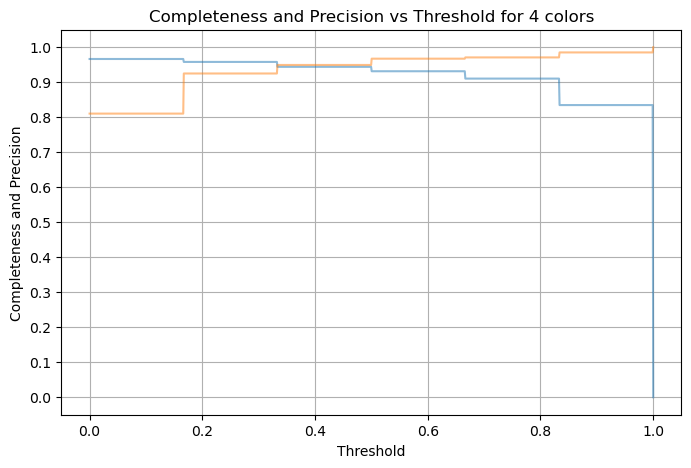

In [31]:
fig9,ax9 = plt.subplots(figsize=(8, 5))
comp_knn, cont_knn = np.zeros(len(thresholds)), np.zeros(len(thresholds))
for n,t in zip(np.arange(len(thresholds)), thresholds):
    y_pred = np.zeros(len(y_test))
    y_pred[clf_knn[3].predict_proba(X_test[:,:4])[:, 1] > t] = 1
    comp_knn[n], cont_knn[n] = completeness_contamination(y_pred, y_test)
ax9.plot(thresholds, comp_knn, alpha = 0.5)
ax9.plot(thresholds, 1-cont_knn, alpha = 0.5)
ax9.set_xlabel('Threshold')
ax9.set_ylabel('Completeness and Precision')
ax9.set_yticks(np.arange(0, 1.1, 0.1))
ax9.set_title('Completeness and Precision vs Threshold for 4 colors')
ax9.grid()